<a href="https://colab.research.google.com/github/MLM1993/myRepository/blob/main/Assignment2_studentfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tranfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model on your choice of dataset from the MedMNIST datasets. ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook.




# 1. Install & Import Packages

In [1]:
!pip install medmnist
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9d7229af977d43e416f6794b880658a2ec1af9ea38bfed2e25fab7c8c7372b01
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale, Compose, Normalize, Lambda
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of channels below that will affect your model)



In [3]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  8
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [4]:
# Define the transforms
train_transforms = Compose([
    Grayscale(num_output_channels=3),  # Convert from 1 channel (greyscale) to 3 channels (RGB)
    ToTensor(),  # Convert the image to a tensor
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])

train_transforms = Compose([
         Grayscale(num_output_channels=3),
         v2.RandomHorizontalFlip(),  # Randomly flip horizontally
         v2.RandomRotation(degrees=15),  # Randomly rotate by up to 15 degrees
         v2.ColorJitter(brightness=0.2, contrast=0.2),
         ToTensor(),
         Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
     ])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [5]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')


100%|██████████| 1.54G/1.54G [01:27<00:00, 17.5MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_224.npz


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [6]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

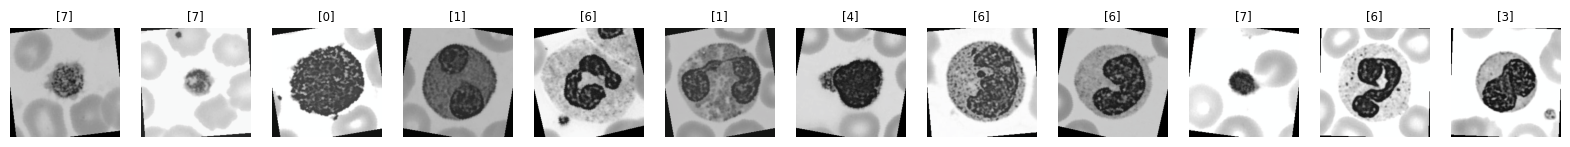

In [7]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [14]:
# Define the model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, n_classes)
)
model.to(device)  # Move model to the selected device

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

# TensorBoard writer
writer = SummaryWriter()

# Training configuration
epochs = 10
print_interval = 100  # Print loss every 100 batches
val_interval = 1  # Run validation every epoch

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()  # Set model to training mode

    running_train_loss = 0.0
    total_train_samples = 0
    correct_train_predictions = 0

    # Training phase
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Squeeze labels to 1D
        labels = torch.squeeze(labels)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training metrics
        running_train_loss += loss.item() * inputs.size(0)  # Accumulate total loss
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

        # Print progress
        if batch_idx % print_interval == 0:
            print(f"Batch {batch_idx}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Calculate average training loss and accuracy
    avg_train_loss = running_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Log to TensorBoard
    writer.add_scalar('Train/Loss', avg_train_loss, epoch)
    writer.add_scalar('Train/Accuracy', train_accuracy, epoch)

    # Validation phase
    if (epoch + 1) % val_interval == 0:
        model.eval()  # Set model to evaluation mode

        running_val_loss = 0.0
        total_val_samples = 0
        correct_val_predictions = 0

        with torch.no_grad():  # No gradient computation for validation
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Squeeze labels to 1D
                labels = torch.squeeze(labels)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                # Update validation metrics
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        # Calculate average validation loss and accuracy
        avg_val_loss = running_val_loss / total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Log to TensorBoard
        writer.add_scalar('Validation/Loss', avg_val_loss, epoch)
        writer.add_scalar('Validation/Accuracy', val_accuracy, epoch)

# Close the TensorBoard writer after training
writer.close()

print("Training complete!")


Epoch 1/10
Batch 0/187: Loss = 2.0431
Batch 100/187: Loss = 0.3394
Train Loss: 0.3753, Train Accuracy: 0.8767
Validation Loss: 0.9320, Validation Accuracy: 0.7249
Epoch 2/10
Batch 0/187: Loss = 0.1684
Batch 100/187: Loss = 0.1058
Train Loss: 0.2023, Train Accuracy: 0.9340
Validation Loss: 1.2653, Validation Accuracy: 0.6957
Epoch 3/10
Batch 0/187: Loss = 0.2852
Batch 100/187: Loss = 0.2269
Train Loss: 0.1701, Train Accuracy: 0.9462
Validation Loss: 0.3461, Validation Accuracy: 0.8803
Epoch 4/10
Batch 0/187: Loss = 0.1158
Batch 100/187: Loss = 0.1850
Train Loss: 0.1730, Train Accuracy: 0.9471
Validation Loss: 0.2147, Validation Accuracy: 0.9311
Epoch 5/10
Batch 0/187: Loss = 0.2253
Batch 100/187: Loss = 0.1266
Train Loss: 0.1500, Train Accuracy: 0.9523
Validation Loss: 0.0934, Validation Accuracy: 0.9690
Epoch 6/10
Batch 0/187: Loss = 0.2660


KeyboardInterrupt: 

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with tensorflow.


In [15]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



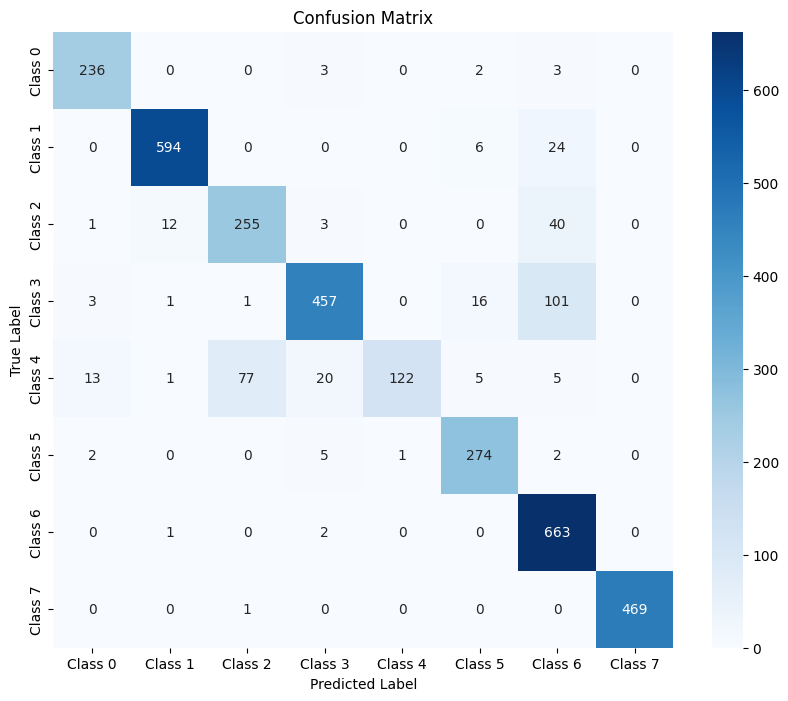

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95       244
     Class 1       0.98      0.95      0.96       624
     Class 2       0.76      0.82      0.79       311
     Class 3       0.93      0.79      0.86       579
     Class 4       0.99      0.50      0.67       243
     Class 5       0.90      0.96      0.93       284
     Class 6       0.79      1.00      0.88       666
     Class 7       1.00      1.00      1.00       470

    accuracy                           0.90      3421
   macro avg       0.91      0.87      0.88      3421
weighted avg       0.91      0.90      0.89      3421



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Placeholder for true and predicted labels
all_y_true = []
all_y_pred = []

# Evaluate on the test dataset
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Squeeze labels to 1D
        labels = torch.squeeze(labels)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        all_y_true.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        all_y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Define class names (replace 'Class 1', 'Class 2', etc., with actual class labels)
classes = [f"Class {i}" for i in range(n_classes)]

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(cm, classes=classes)

# Print classification report
print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=classes))

 # Comments about your Approach

I have used a pre trained ResNet18 which seemed to balance performance and run time well. I had some difficulty with label compatability as I was using ChestMSINT which is multi label so I switched to BLOODMSINT.

I had intended to add automatic stopping to my training loop but on one of my first runs after patching up the issues from using chest I reached validation accuracy of .969 which exceeds the .959 benchmark listed on MedMNIST website so I manually stopped the loop.

The baseline pre trained ResNet18 model was overfitting, by the end of epoch 2 the training accuracy would be 95%+ and test accuracy, having initially trended upwards would be heading back down. I added random horizontal flip, rotation and colour jitter by way of augmentation. I also added dropout layers and weight decay to my Adam optimizer. This seemed to be sufficient to put manners on the overfitting.

Next steps wise, eyeballing the confusion matrix almost all of my error comes from class three and four so I would potentially look at some class specific augmentation to give the model more looks at these classes without adding unnecessary runtime via additional augmentation of classes which are already performing well.